In [1]:
import math
import graphviz
import numpy as np
import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt

In [2]:
# Create noise models with specified standard deviations (sigmas).
# For Pose2, the noise is on (x, y, theta).
# Note: gtsam.Point3 is used here to represent the 3 sigmas (dx, dy, dtheta)

# Prior noise on the first pose (x, y, theta) - sigmas = [0.3m, 0.3m, 0.1rad]
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
# Odometry noise (dx, dy, dtheta) - sigmas = [0.2m, 0.2m, 0.1rad]
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))

In [3]:
# 1. Create a factor graph container
graph = gtsam.NonlinearFactorGraph()

In [4]:
# 2a. Add a prior on the first pose (key 1)
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

In [5]:
# 2b. Add odometry factors (Between Factors)
# Between poses 1 and 2:
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), ODOMETRY_NOISE))
# Between poses 2 and 3:
graph.add(gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
# Between poses 3 and 4:
graph.add(gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
# Between poses 4 and 5:
graph.add(gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))

In [6]:
# 2c. Add the loop closure constraint
# This factor connects pose 5 back to pose 2
# The measurement is the expected relative pose from 5 to 2
graph.add(gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))

In [7]:
print("\nFactor Graph:\n{}".format(graph))


Factor Graph:
NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on 1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.3; 0.3; 0.1];

Factor 1: BetweenFactor(1,2)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 2: BetweenFactor(2,3)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 3: BetweenFactor(3,4)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 4: BetweenFactor(4,5)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 5: BetweenFactor(5,2)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];




In [8]:
# 3. Create the initial estimate for the solution
# These values are deliberately incorrect to show optimization.
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))

print("\nInitial Estimate:\n{}".format(initial_estimate))


Initial Estimate:
Values with 5 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2.1, 2.1, -1.57079633)




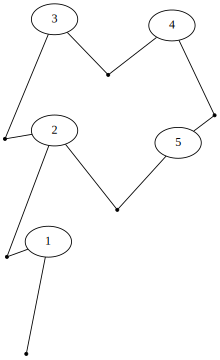

In [9]:
display(graphviz.Source(graph.dot(initial_estimate), engine='neato'))


In [10]:
# Write the initial estimate poses to data/unoptimized.txt for simulation replay
import os
os.makedirs('data', exist_ok=True)
with open('data/unoptimized.txt', 'w') as f:
    for i in range(1, 6):
        pose = initial_estimate.atPose2(i)
        f.write(f"{pose.x()} {pose.y()} {pose.theta()}\n")
print("Unoptimized poses written to data/unoptimized.txt")

Unoptimized poses written to data/unoptimized.txt


## OPTIMIZE

In [11]:
parameters = gtsam.GaussNewtonParams()

parameters.setRelativeErrorTol(1e-5)
parameters.setMaxIterations(100)

optimezer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
result = optimezer.optimize()
print("\nFinal Result:\n{}".format(result))


Final Result:
Values with 5 values:
Value 1: (gtsam::Pose2)
(-1.27455483e-20, 8.10527674e-20, 3.07189987e-20)

Value 2: (gtsam::Pose2)
(2, 1.78514217e-19, 4.34262714e-20)

Value 3: (gtsam::Pose2)
(4, -3.42173202e-11, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2, 2, -1.57079633)




In [12]:
marginals = gtsam.Marginals(graph, result)
print("\nFinal Result Covariances:\n")
for i in range(1, 6):
    print("x{} covariance:\n{}".format(i, marginals.marginalCovariance(i)))


Final Result Covariances:

x1 covariance:
[[ 9.00000000e-02  1.46353224e-19  7.44508834e-20]
 [ 1.46353224e-19  9.00000000e-02 -6.39488462e-18]
 [ 7.44508834e-20 -6.39488462e-18  1.00000000e-02]]
x2 covariance:
[[1.30000000e-01 5.20222409e-19 1.67996663e-19]
 [5.20222409e-19 1.70000000e-01 2.00000000e-02]
 [1.67996663e-19 2.00000000e-02 2.00000000e-02]]
x3 covariance:
[[ 3.62000000e-01 -3.29290718e-12  6.20000000e-02]
 [-3.29290502e-12  1.62000000e-01 -2.00000000e-03]
 [ 6.20000000e-02 -2.00000000e-03  2.65000000e-02]]
x4 covariance:
[[ 0.268 -0.128  0.048]
 [-0.128  0.378 -0.068]
 [ 0.048 -0.068  0.028]]
x5 covariance:
[[ 0.202   0.036  -0.018 ]
 [ 0.036   0.26   -0.051 ]
 [-0.018  -0.051   0.0265]]


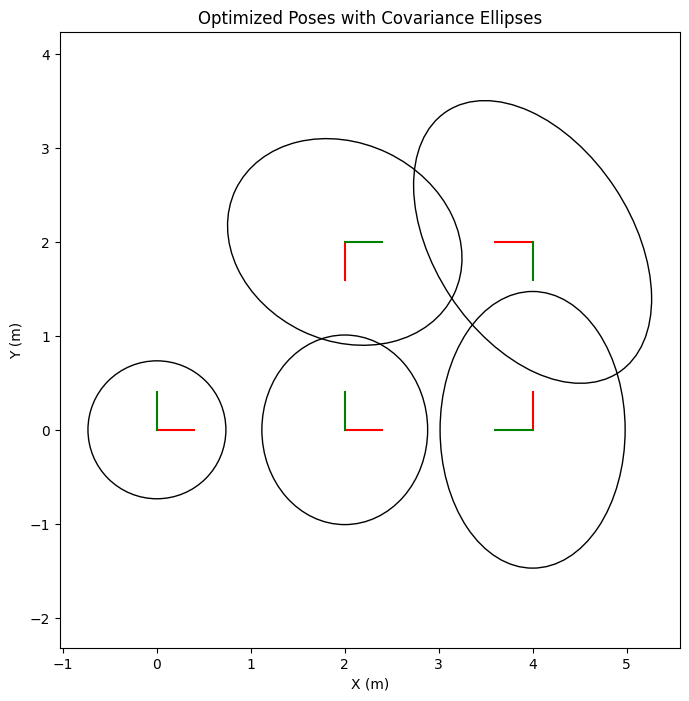

In [13]:
fig = plt.figure(1, figsize=(8, 8))
for i in range(1, 6):
    gtsam_plot.plot_pose2(fig.number, result.atPose2(i), axis_length=0.4, covariance=marginals.marginalCovariance(i))

plt.title("Optimized Poses with Covariance Ellipses")
plt.axis('equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

In [ ]:
# Write the optimized poses to data/optimized.txt for simulation replay
import os
os.makedirs('data', exist_ok=True)
with open('data/optimized.txt', 'w') as f:
    for i in range(1, 6):
        pose = result.atPose2(i)
        f.write(f"{pose.x()} {pose.y()} {pose.theta()}\n")
print("Optimized poses written to data/optimized.txt")